# Application of ML models for regression and classification problems

In [29]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.datasets import make_moons, make_circles

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import GridSearchCV, PredefinedSplit

import time

import math

from mlxtend.plotting import plot_decision_regions
import itertools
import matplotlib.gridspec as gridspec

from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings('ignore')

## Classification models and Feature Engineering

In [30]:
def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise, random_state=0xC0FFEE)
    if not n_sun:
        return X_moons, y_moons
    
    np.random.seed(0xC0FFEE)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += np.random.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)

    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)

    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X = X @ R
    
    return X, y

X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)

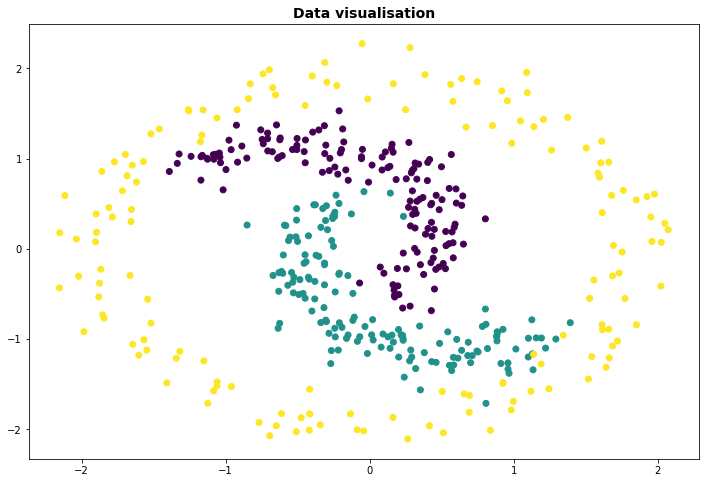

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Data visualisation', fontsize = 14, fontweight = 'bold')
plt.show()

### Decision Rules Plotting

We are going to fit the following classifiers on features `X` to target `y`:
* Decision Tree with small depth ($\leq 4$);
* Random Forest with a small number of trees ($\leq 20$) of small depth ($\leq 4$);
* Logistic Regression;
* Support Vector Machine with RBF kernel;
* Gaussian Naive Bayes;
* k-Nearest Neighbor Classifier with a small number of neighbors;

For all the fitted classifiers there are decision regions plots.

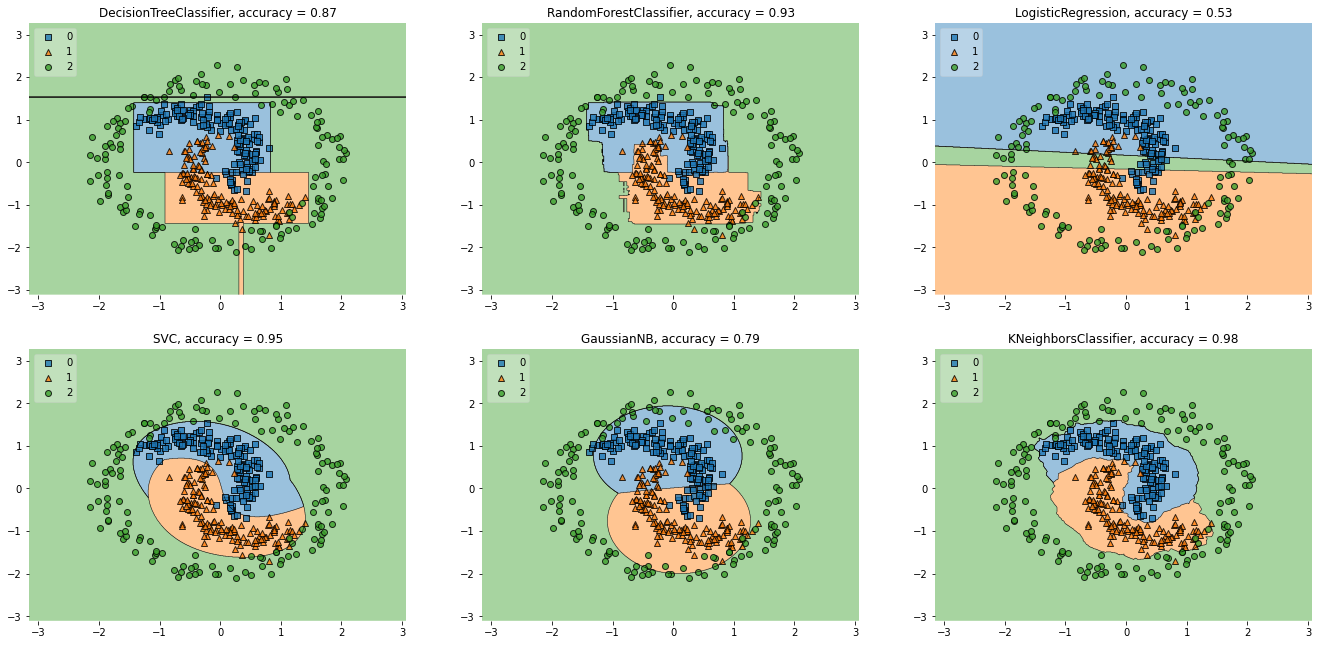

In [32]:

dec_tree = DecisionTreeClassifier(max_depth=4, random_state=45)
dec_tree.fit(X,y)
predicted_train_tree = dec_tree.predict(X)
accuracy_train_tree = round(accuracy_score(predicted_train_tree, y),2)

rand_forest = RandomForestClassifier(max_leaf_nodes=20, max_depth=4, n_jobs=-1 , random_state=45)
rand_forest.fit(X,y)
predicted_rand_forest = rand_forest.predict(X)
accuracy_rand_forest = round(accuracy_score(predicted_rand_forest, y),2)

logic_reg = LogisticRegression(solver="liblinear", n_jobs=-1 , random_state=45)
logic_reg.fit(X,y)
predicted_logic_reg = logic_reg.predict(X)
accuracy_logic_reg = round(accuracy_score(predicted_logic_reg, y),2)

SVM = SVC(kernel="rbf", random_state=45)
SVM.fit(X,y)
predicted_SVM = SVM.predict(X)
accuracy_SVM = round(accuracy_score(predicted_SVM, y),2)

GNB = GaussianNB()
GNB.fit(X,y)
predicted_GNB = GNB.predict(X)
accuracy_GNB = round(accuracy_score(predicted_GNB, y),2)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X,y)
predicted_knn = knn.predict(X)
accuracy_knn = round(accuracy_score(predicted_knn, y),2)

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(23, 11))

labels = ['DecisionTreeClassifier, accuracy = '+str(accuracy_train_tree),
          'RandomForestClassifier, accuracy = '+str(accuracy_rand_forest),
          'LogisticRegression, accuracy = '+str(accuracy_logic_reg),
          'SVC, accuracy = '+str(accuracy_SVM), 'GaussianNB, accuracy = '+str(accuracy_GNB),'KNeighborsClassifier, accuracy = '+str(accuracy_knn)]

for alg, label, grd in zip([dec_tree, rand_forest, logic_reg, SVM, GNB, knn],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y,
                                clf=alg, legend=2 )
    plt.title(label)

plt.show()


From plots above we can observe, that logistic regression works quite bad, comparing to other models. But we can improve the work of our classifiers by feature engineering.

### Improving models by Feature Engineering


Feature engineering applied: 
  
  Logistic regression: 
   - Scaling (Standart scaler) 
   - Polynomial features (8) 
 
  Random Forest: 
   - Polynomial features (15)


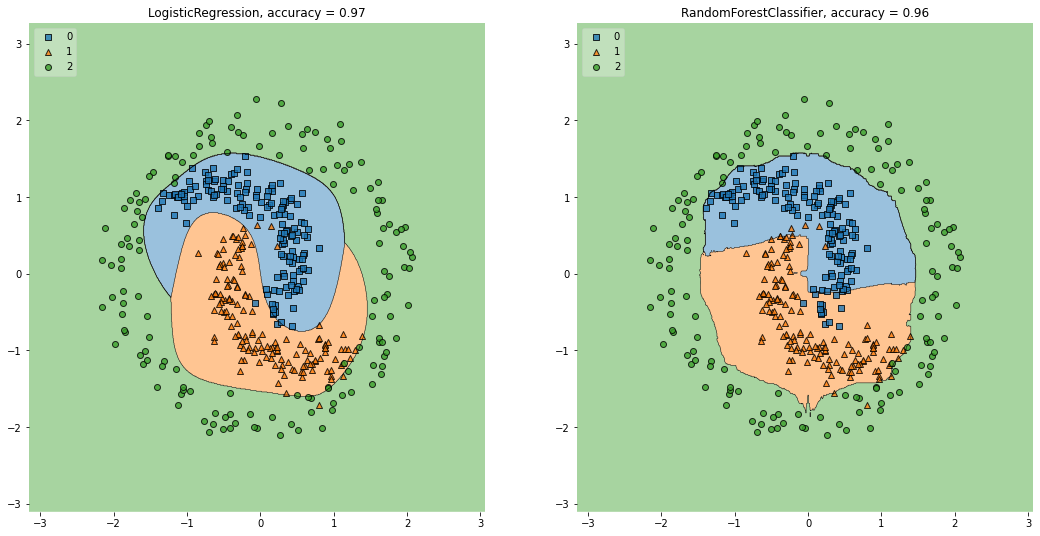

In [11]:

pipe_logic_reg = Pipeline([('scaler', StandardScaler()), ('polynomial_features', PolynomialFeatures(degree = 8)), ('logistic_regression',LogisticRegression(solver="liblinear", n_jobs=-1 , random_state=45))])
pipe_logic_reg.fit(X, y)
predicted_logic_reg = pipe_logic_reg.predict(X)
accuracy_logic_reg = round(accuracy_score(predicted_logic_reg, y),2)

pipe_forest = Pipeline([('polynomial_features', PolynomialFeatures(degree = 15)), ('forest',RandomForestClassifier(max_leaf_nodes=20, max_depth=4, n_jobs=-1 , random_state=45))])
pipe_forest.fit(X, y)
predicted_forest = pipe_forest.predict(X)
accuracy_forest = round(accuracy_score(predicted_forest, y),2)

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(18, 9))

labels = ['LogisticRegression, accuracy = '+str(accuracy_logic_reg), 'RandomForestClassifier, accuracy = '+str(accuracy_forest)]

for alg, label, grd in zip([pipe_logic_reg, pipe_forest],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y,
                                clf=alg, legend=2 )
    plt.title(label)

print(f'Feature engineering applied: \n  ')
print(f'  Logistic regression: \n   - Scaling (Standart scaler) \n   - Polynomial features (8) \n ')
print(f'  Random Forest: \n   - Polynomial features (15)')

plt.show()


For **Logistic Regression** it is clear that the use of polynomial feautures will improve the algorithm if the data has a non-linear behavior. As far as logistic regression trying to construct the decision boundary between two classes as a linear function but the data at the same time has a non-linear view we can expect our algorithm to build a fully bad prediction model, because we can not describe non-linear behaviour with linear function And also features scalling make sense for **Logistic Regression** with regularization, because in this case we have a penalty for big coefficients (L1 or L2 norm). So, feature scaling will affect the features variance and as a result features coeffitients.

For **Random Forest** we have no sense to implement scaling as simple linear transformations on our data will make no difference for training a **Random Forest**. On the other hand we still can get improvement using polynomial features, as in this case we provide algorithm with quite more number of features.

## Bagging for Regression models


In [13]:
data = pd.read_csv('data/concrete.csv').astype(float)
X = data.drop('concrete_compressive_strength', axis=1)
y = data.concrete_compressive_strength
n = len(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=int(n*0.15), random_state=0xC0FFEE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=int(n*0.15), random_state=0xC0FFEE)

data.sample(3).sort_index()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
381,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28.0,81.75
714,153.0,102.0,0.0,192.0,0.0,888.0,943.1,7.0,8.37
950,326.5,0.0,137.9,199.0,10.8,801.1,792.5,28.0,38.63


### Hyperparameters tuning (Grid Search)

In [14]:

# Random forest GridSearch
split_index = [-1 if x in X_train.index else 0 for x in X_train_val.index]

pds = PredefinedSplit(test_fold = split_index)

grid_rand_forest_reg = GridSearchCV(estimator = RandomForestRegressor(criterion = "squared_error",random_state=0xC0FFEE, n_jobs = -1 ),
                   cv=pds,
                   param_grid={'n_estimators': [200, 400], # Nº of Decision Trees  
                               'max_depth': [10,18, 20, 22], # The Maximum Depth of the Individual Trees
                               'max_features': [None, 0.3, 0.4, 0.5, 0.8], # The Number of random features to consider at each split
                               }, 
                   n_jobs=-1, scoring = 'neg_mean_squared_error')

grid_rand_forest_reg.fit(X_train_val, y_train_val)
best_param_rand_forest_reg = grid_rand_forest_reg.best_params_

#Random forest training with optimal parameters
rand_forest_reg = RandomForestRegressor(n_estimators = best_param_rand_forest_reg['n_estimators'],
                                        max_depth = best_param_rand_forest_reg['max_depth'], 
                                        max_features = best_param_rand_forest_reg['max_features'],
                                        criterion = "squared_error",random_state=0xC0FFEE, n_jobs = -1)

rand_forest_reg.fit(X_train,y_train)

train_predict_rand_forest_reg = rand_forest_reg.predict(X_train)
valid_predict_rand_forest_reg = rand_forest_reg.predict(X_val)
test_predict_rand_forest_reg = rand_forest_reg.predict(X_test)

print(f'Random Forest Regression (optimal parameters: {best_param_rand_forest_reg})')
print(f'Train score (MSE): {mse(train_predict_rand_forest_reg,y_train)}')
print(f'Validation score (MSE): {mse(valid_predict_rand_forest_reg,y_val)}')
print(f'Test score (MSE): {mse(test_predict_rand_forest_reg,y_test)}')

# Extra Trees GridSearch
grid_extra_trees = GridSearchCV(estimator = ExtraTreesRegressor(criterion = "squared_error",random_state=0xC0FFEE, n_jobs = -1),
                   cv=pds,
                   param_grid={'n_estimators': [200, 400], # Nº of Decision Trees  
                               'max_depth': [10,18, 20, 22], # The Maximum Depth of the Individual Trees
                               'max_features': [None, 0.3, 0.4, 0.5, 0.8], # The Number of random features to consider at each split
                               }, 
                   n_jobs=-1, scoring = 'neg_mean_squared_error')

grid_extra_trees.fit(X_train_val, y_train_val)
best_param_extra_trees = grid_extra_trees.best_params_

# Extra Trees training with optimal parameters
extra_trees = ExtraTreesRegressor(n_estimators = best_param_extra_trees['n_estimators'],
                                        max_depth = best_param_extra_trees['max_depth'], 
                                        max_features = best_param_extra_trees['max_features'],
                                        criterion = "squared_error",random_state=0xC0FFEE, n_jobs = -1)

extra_trees.fit(X_train,y_train)

train_predict_extra_trees = extra_trees.predict(X_train)
valid_predict_extra_trees = extra_trees.predict(X_val)
test_predict_extra_trees = extra_trees.predict(X_test)

print('')
print(f'Extra Trees Regression (optimal parameters: {best_param_extra_trees})')
print(f'Train score (MSE): {mse(train_predict_extra_trees,y_train)}')
print(f'Validation score (MSE): {mse(valid_predict_extra_trees,y_val)}')
print(f'Test score (MSE): {mse(test_predict_extra_trees,y_test)}')


Random Forest Regression (optimal parameters: {'max_depth': 18, 'max_features': 0.5, 'n_estimators': 400})
Train score (MSE): 4.781953820321192
Validation score (MSE): 19.341551614236394
Test score (MSE): 23.914268756491527

Extra Trees Regression (optimal parameters: {'max_depth': 20, 'max_features': 0.8, 'n_estimators': 400})
Train score (MSE): 1.3293120022832483
Validation score (MSE): 16.22749789947413
Test score (MSE): 21.424904935243


For both regressors we obtained poor MSEs for validation and test datasets, comparing to MSE on train set. One of the reasons of such behavior is the fact that the model was trained on train data and optimized on validation data. This fact can explain why validation MSE is better then test's but still poorer then train's. The fact of poor MSEs in general could be explained by assumption that train dataset was too little to provide good training procedure.

Extra trees perform better because of random threshold choosing, which helps algorithm to avoid overfitting.

## Boosting

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [16]:
### Plot the dataset

X, y = make_moons(n_samples=1000, noise=0.3, random_state=0xC0FFEE)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

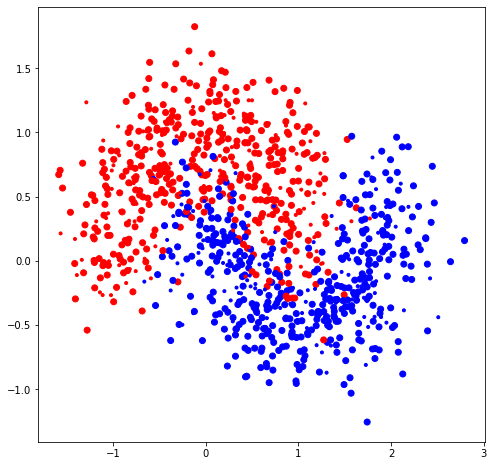

In [18]:
# Plot the training points
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)
plt.show()

In [19]:
from sklearn.tree import DecisionTreeClassifier # base classifier

### AdaBoost alphas and distributions

In [20]:
def ada_boost_alpha(y, y_pred_t, distribution):

    w=[]
    for i in range(distribution.size):
      if y[i]*y_pred_t[i] <= 0:
        w.append(distribution[i])
    N = np.sum(w)
    alpha = 1/2*np.log((1-N)/N)

    return alpha

def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):

    distribution = np.multiply(distribution,np.exp(-alpha_t*np.multiply(y,y_pred_t)))
    C = np.sum(distribution)
    distribution = distribution/C

    return distribution

### Boosting implementation

In [21]:
class Boosting():

    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = []
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            
            # make a prediction
            y_pred = self.classifiers[-1].predict(X)
            # update alphas, append new alpha to self.alphas
            self.alphas.append(self.get_alpha(y, y_pred, distribution))
            # update distribution and normalize
            distribution = self.update_distribution(y, y_pred, distribution, self.alphas[i])

    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        predictions = []
        for classifier in self.classifiers:
          predictions.append(classifier.predict(X))

        #get the weighted votes of the classifiers
        out = []
        j=0

        while j<len(predictions[0]):
          pred_val =[]

          for i in range(len(predictions)):
            pred_val.append(predictions[i][j])

          out.append(np.sign(np.sum(np.multiply(self.alphas,pred_val))))
          j+=1

        out = np.array(out)

        return out

In [22]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=5),
                   n_estimators=100)

In [23]:
classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.895
accuracy ada_boost_sklearn: 0.89


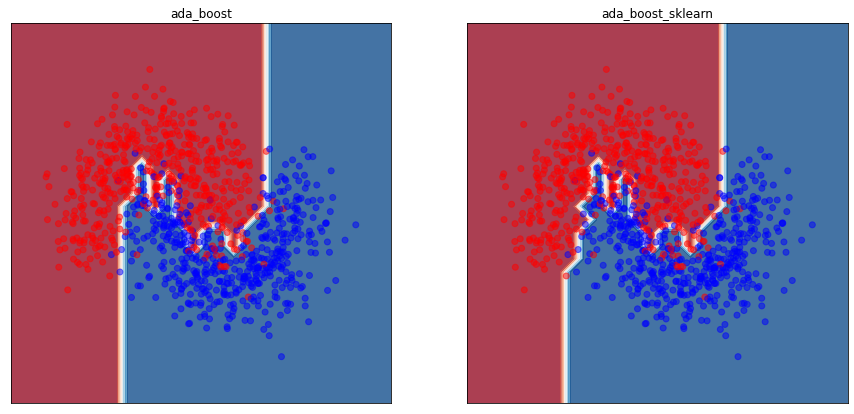

In [24]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

## Gradient Boosting 

In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('data/telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']
data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0xC0FFEE)

### XGBoost vs. Random Forest 

Training time for xgb: 0.5108610330000829
Training time for random forest: 1.3900387139999566
Average precision score for XGBoost: 0.7232728881431598
Average precision score for XGBoost: 0.7269518721488126


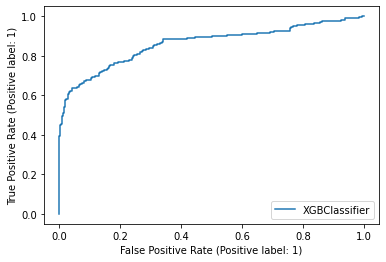

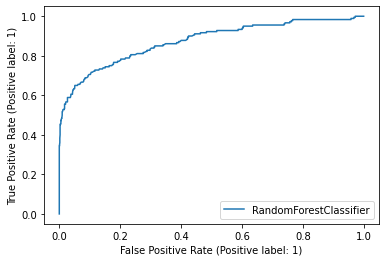

In [26]:
# XGBC init and train
XGBC = XGBClassifier(max_depth=4, learning_rate=0.08, n_estimators=200, n_jobs=-1, random_state=45, reg_alpha=1, reg_lambda=10)

t_start_XGBC = time.perf_counter()
XGBC.fit(X_train, y_train)
XGBC_train_time = time.perf_counter() - t_start_XGBC

# Random forest init and train
RFC = RandomForestClassifier(max_depth = 18, max_features = 0.5, n_estimators = 200, n_jobs=-1, random_state=45)

t_start_RFC = time.perf_counter()
RFC.fit(X_train, y_train)
RFC_train_time = time.perf_counter() - t_start_RFC

# Printing training time
print(f'Training time for xgb: {XGBC_train_time}')
print(f'Training time for random forest: {RFC_train_time}')

# XGBC average precision score
test_probabilities_XGBC = XGBC.predict_proba(X_test)[:, 1]

XGBC_average_precision_score = average_precision_score(y_test, test_probabilities_XGBC)
print(f'Average precision score for XGBoost: {XGBC_average_precision_score}')

# Random forest average precision score
test_probabilities_RFC = RFC.predict_proba(X_test)[:, 1]

RFC_average_precision_score = average_precision_score(y_test, test_probabilities_RFC)
print(f'Average precision score for XGBoost: {RFC_average_precision_score}')

# XGBC ROC curve
false_positive_rates_XGBC, true_positive_rates_XGBC, threshold_XGBC = roc_curve(y_test, test_probabilities_XGBC)

plt.figure()
plt.plot(false_positive_rates_XGBC, true_positive_rates_XGBC, label = 'XGBClassifier')
plt.xlabel('False Positive Rate (Positive label: 1)')
plt.ylabel('True Positive Rate (Positive label: 1)')
plt.legend(loc="lower right");

# Random forest ROC curve
false_positive_rates_RFC, true_positive_rates_RFC, threshold_RFC = roc_curve(y_test, test_probabilities_RFC)

plt.figure()
plt.plot(false_positive_rates_RFC, true_positive_rates_RFC, label = 'RandomForestClassifier')
plt.xlabel('False Positive Rate (Positive label: 1)')
plt.ylabel('True Positive Rate (Positive label: 1)')
plt.legend(loc="lower right");


### Feature importances 


Text(0.5, 1.0, 'Random Forest Feature Importances')

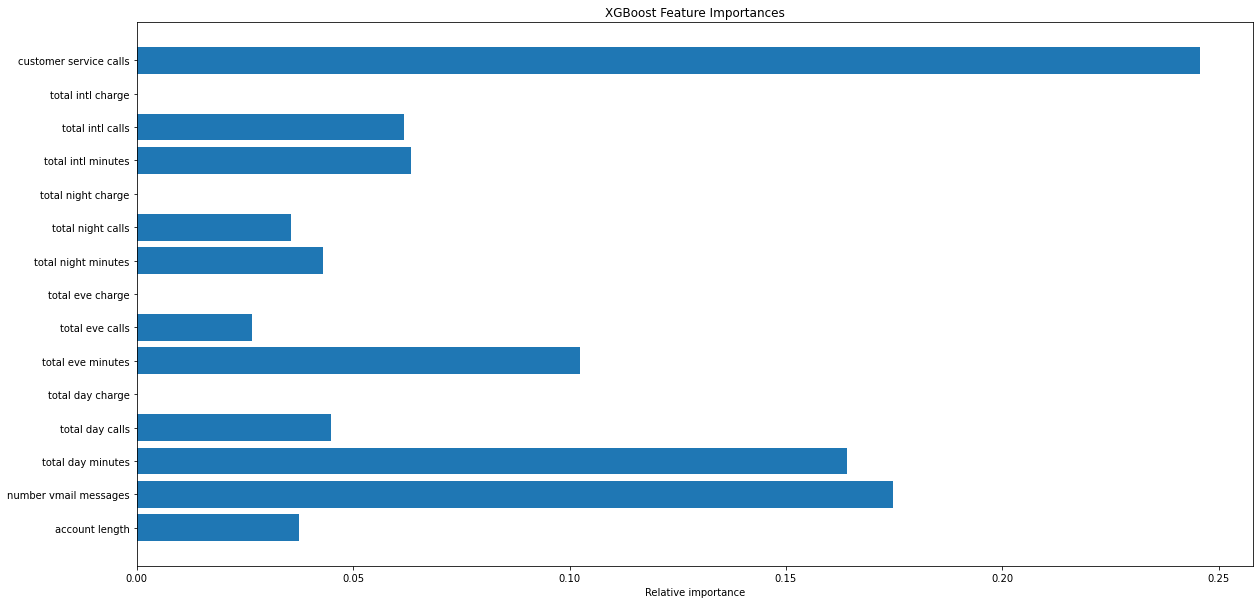

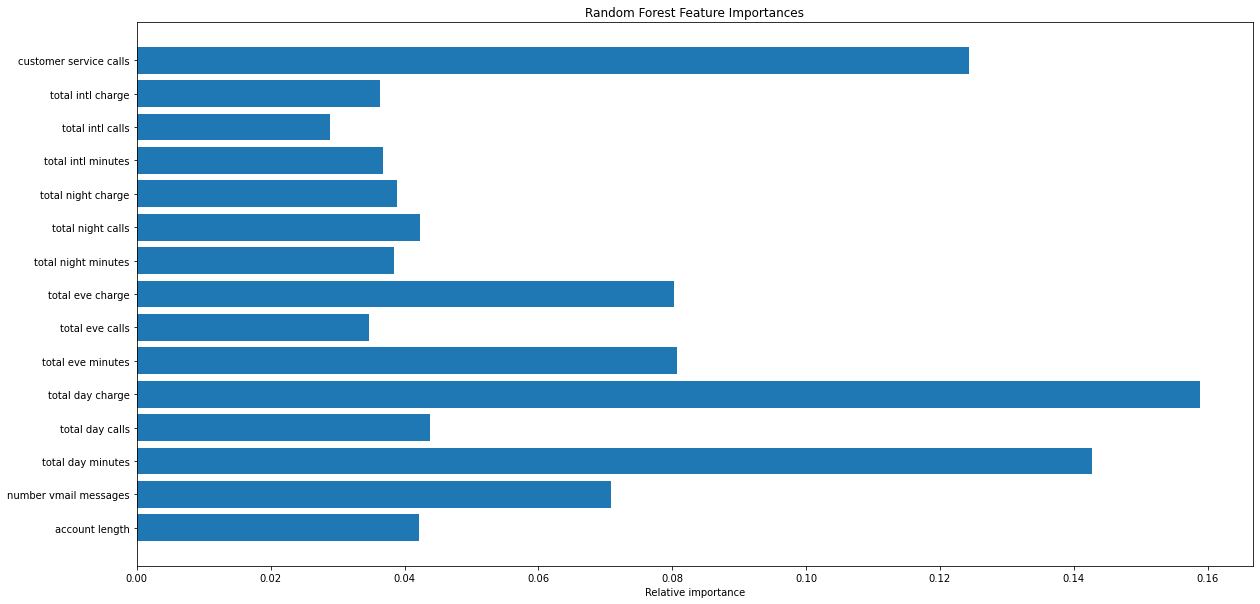

In [27]:
plt.figure(figsize = (20,10))
plt.barh(X_train.columns,(XGBC.feature_importances_))
plt.xlabel('Relative importance')
plt.title('XGBoost Feature Importances')

plt.figure(figsize = (20,10))
plt.barh(X_train.columns,RFC.feature_importances_)
plt.xlabel('Relative importance')
plt.title('Random Forest Feature Importances') 


Using Random forest for every tree we randomly schoose features for node splitting, not based on similarity score and gain. As a result, the features, which are more important for XGBoost, can become less important for Random forest, and vice versa.